<a href="https://colab.research.google.com/github/yesong98/Going-Deeper/blob/main/GD_04_CutMix_or_Mixup(Both)_%EB%B9%84%EA%B5%90%EC%8B%A4%ED%97%98_%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CutMix 또는 Mixup 비교실험 하기

<루브릭>

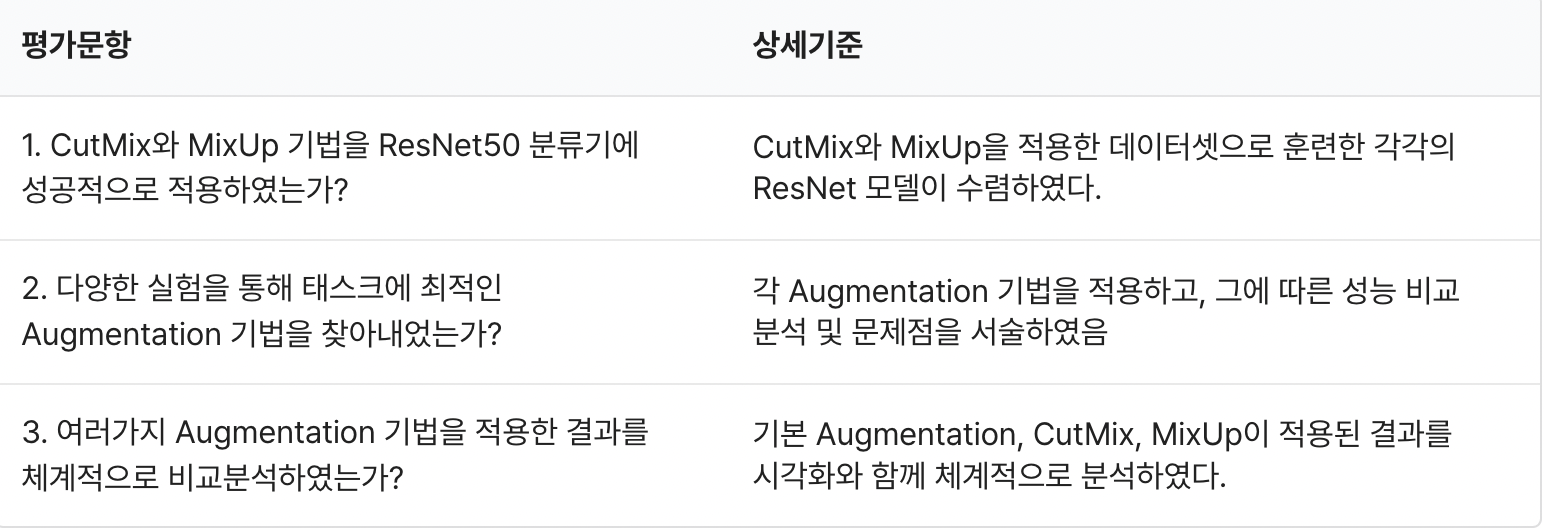

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as npZ
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation을 적용한 데이터셋 만들기

## (1) 데이터 불러오기


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteG554LZ/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteG554LZ/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


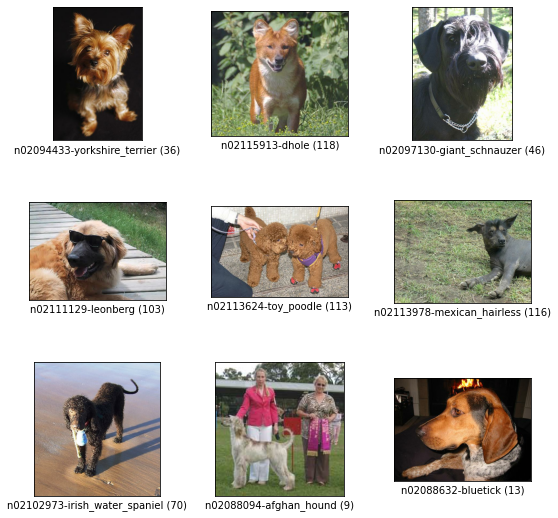

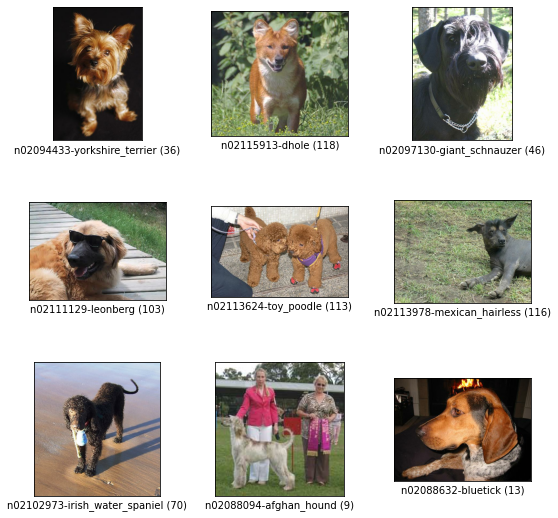

In [ ]:
tfds.show_examples(ds_train, ds_info)

## (2) Augmentation 적용하기


In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)



#1) Cutmix Augmentation

-  이미지 데이터를 자르고 섞는다고 생각
- CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법
-CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함
- 논문에서 가져온 아래표를 보면 Mixup보다 Cutmix가 성능이 좋아보인다.

## (1) 이미지 섞기


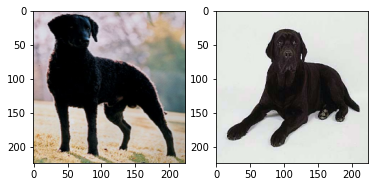

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(64, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(63, shape=(), dtype=int32) tf.Tensor(208, shape=(), dtype=int32)


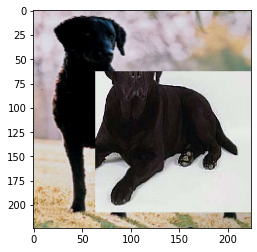

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

## (2) 라벨 섞기


In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.5376276 , 0.        , 0.46237245, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

이제 거의다 준비되었습니다.
위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 2) Mixup Augmentation
- Mixup은 특정 비율로 픽셀별 값을 섞는 방식
- 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단


In [ ]:
num_classes = ds_info.features["label"].num_classes

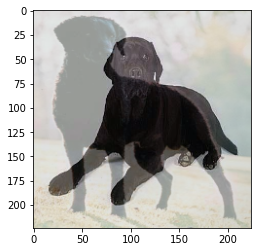

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.34144282 0.         0.6585572  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
#mixup 함수구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#  2. 모델만들기


##1)Model

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix: #cutmix
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [ ]:
from keras.callbacks import EarlyStopping
lr = 0.005
batch_size =16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=20

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=False,
    with_mixup=False
)
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=False,
    with_mixup=False
)
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=True,
    with_mixup=False
)
ds_train_mixup = apply_normalize_on_dataset(
    ds_train,
    batch_size = batch_size,
    with_aug= False,
    with_cutmix=False,
    with_mixup=True    
)

ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True,
    with_mixup=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [ ]:
tf.random.set_seed(1994)

## 2)train

### (1)ResNet50, Normal Data

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_normal = resnet50.fit(
    ds_train_normal, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)
del resnet50

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 107s 120ms/step - loss: 2.7414 - accuracy: 0.3622 - val_loss: 3.4128 - val_accuracy: 0.2037
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.9630 - accuracy: 0.7546 - val_loss: 1.1011 - val_accuracy: 0.6756
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.4265 - accuracy: 0.9128 - val_loss: 0.9906 - val_accuracy: 0.7107
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 0.1702 - accuracy: 0.9821 - val_loss: 0.9601 - val_accuracy: 0.7172
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0727 - accuracy: 0.9982 - val_loss: 0.9649 - val_accuracy: 0.7218
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0414 - accuracy: 0.9994 - val_loss: 0.9723 - val_accuracy: 0.7211
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.9850 - val_accuracy: 0.

### (2)Augmentation data

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)
del aug_resnet50

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 118ms/step - loss: 2.9480 - accuracy: 0.3139 - val_loss: 1.9657 - val_accuracy: 0.4565
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 1.3223 - accuracy: 0.6407 - val_loss: 1.5196 - val_accuracy: 0.5733
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 0.8517 - accuracy: 0.7674 - val_loss: 1.2540 - val_accuracy: 0.6333
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 0.5543 - accuracy: 0.8556 - val_loss: 1.2686 - val_accuracy: 0.6414
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 0.3738 - accuracy: 0.9115 - val_loss: 1.2069 - val_accuracy: 0.6583
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.2410 - accuracy: 0.9525 - val_loss: 1.3943 - val_accuracy: 0.6233
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 0.1620 - accuracy: 0.9747 - val_loss: 1.1769 - val_accuracy: 0.6

### (3) Resnet50 cutmix

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)
del cutmix_resnet50

Epoch 1/20
750/750 [==============================] - 97s 121ms/step - loss: 4.1449 - accuracy: 0.1542 - val_loss: 3.6710 - val_accuracy: 0.1558
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 3.1813 - accuracy: 0.3731 - val_loss: 1.4149 - val_accuracy: 0.6151
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.8413 - accuracy: 0.4767 - val_loss: 1.2239 - val_accuracy: 0.6604
Epoch 4/20
750/750 [==============================] - 90s 119ms/step - loss: 2.6291 - accuracy: 0.5488 - val_loss: 1.1145 - val_accuracy: 0.6898
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.4523 - accuracy: 0.5987 - val_loss: 1.0412 - val_accuracy: 0.7094
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.3570 - accuracy: 0.6395 - val_loss: 1.0260 - val_accuracy: 0.7181
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2509 - accuracy: 0.6728 - val_loss: 1.0562 - val_ac

### (4) ResNet50 Mixup data

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)
del mixup_resnet50

Epoch 1/20
750/750 [==============================] - 97s 120ms/step - loss: 4.0229 - accuracy: 0.1779 - val_loss: 4.0624 - val_accuracy: 0.1114
Epoch 2/20
750/750 [==============================] - 90s 119ms/step - loss: 3.0101 - accuracy: 0.4381 - val_loss: 1.3661 - val_accuracy: 0.6158
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.7126 - accuracy: 0.5403 - val_loss: 1.1809 - val_accuracy: 0.6627
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 2.5310 - accuracy: 0.6060 - val_loss: 1.1639 - val_accuracy: 0.6669
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.4348 - accuracy: 0.6482 - val_loss: 1.1270 - val_accuracy: 0.6904
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.3056 - accuracy: 0.6927 - val_loss: 1.1487 - val_accuracy: 0.6719
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2243 - accuracy: 0.7300 - val_loss: 1.1490 - val_ac

### (5) ResNet50, Augmented + CutMix data + Mixup data

In [ ]:
all_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
all_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all = all_resnet50.fit(
    ds_train_all, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)
del all_resnet50

Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 4.3582 - accuracy: 0.1008 - val_loss: 2.5601 - val_accuracy: 0.3397
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 3.4084 - accuracy: 0.3132 - val_loss: 1.6758 - val_accuracy: 0.5377
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 3.1003 - accuracy: 0.3987 - val_loss: 1.4775 - val_accuracy: 0.5864
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 2.8792 - accuracy: 0.4651 - val_loss: 1.4108 - val_accuracy: 0.6096
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.7341 - accuracy: 0.5067 - val_loss: 1.4038 - val_accuracy: 0.6119
Epoch 6/20
750/750 [==============================] - 90s 119ms/step - loss: 2.6443 - accuracy: 0.5360 - val_loss: 1.3056 - val_accuracy: 0.6346
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 2.5527 - accuracy: 0.5606 - val_loss: 1.3132 - val_ac

#4. 시각화

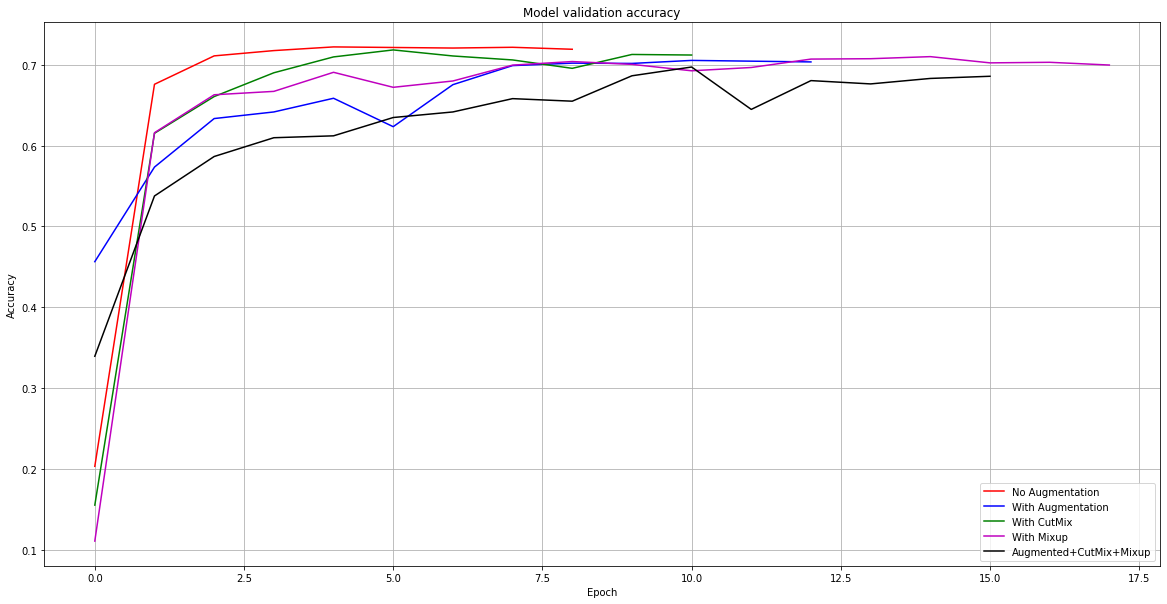

In [ ]:
#val_accuracy
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup', 'Augmented+CutMix+Mixup'], loc='best')
plt.grid(True)
plt.savefig('fig2_Accuracy.png')
plt.show()

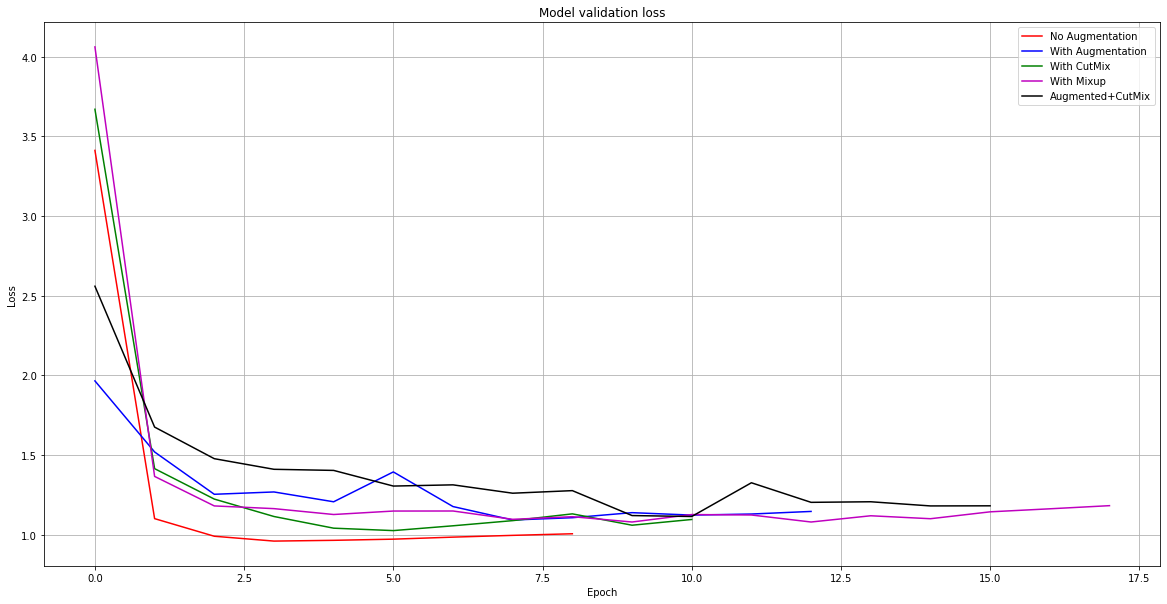

In [ ]:
#val_loss
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup','Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig2_loss.png')
plt.show()

# 5. Augmentation에 의한 모델 성능 비교(위 그래프 확대)

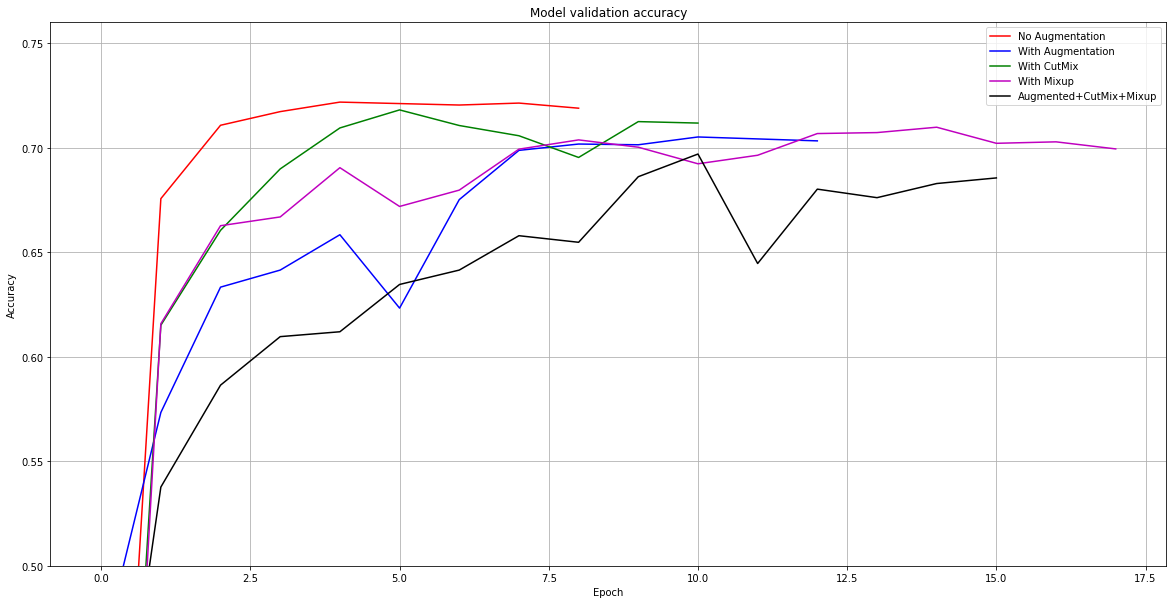

In [ ]:
#val_accuracy
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup', 'Augmented+CutMix+Mixup'], loc='best')
plt.grid(True)
plt.ylim(0.50, 0.76)
plt.show()

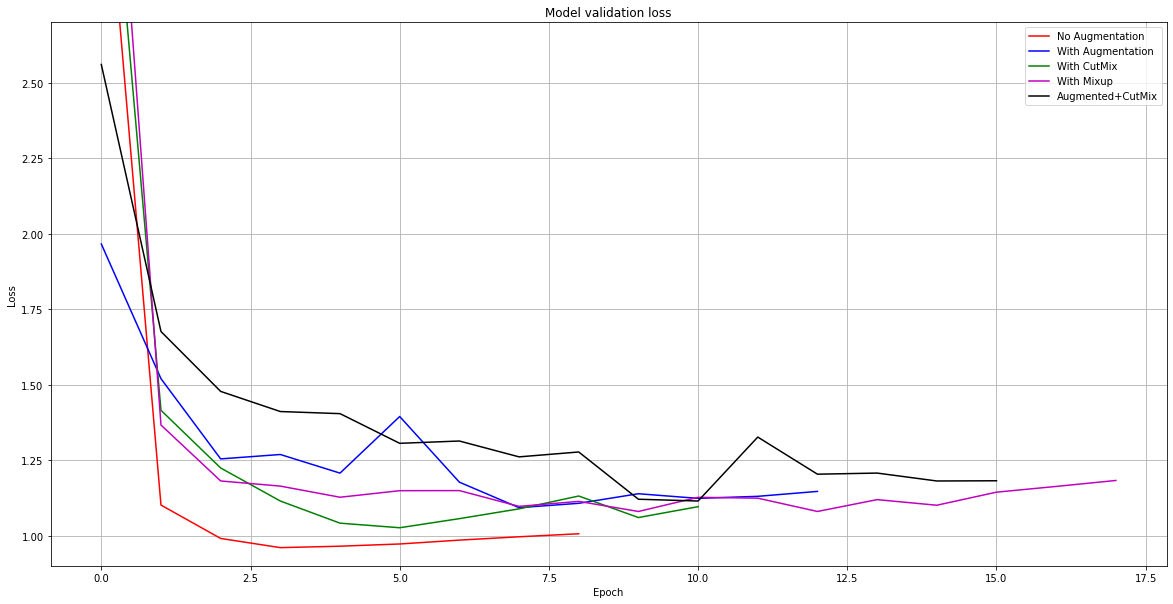

In [ ]:
#val_loss
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup','Augmented+CutMix'], loc='best')
plt.grid(True)
plt.ylim(0.90, 2.70)
plt.show()

# 📓결과
- 논문에서 이야기 한 것과 같이 Mixup, cutmix로 resnet-50을 사전훈련한 뒤 전이 학습을 수행한 것으로 결과는 위의 그래프와 같다. 
object detection에 대해 mixup의 경우 성능이 더 안좋아지지만 cutmix기법은 안정적으로 더 좋아지는 것 확인된다.

- Accuracy 결과  
  (Normal) Augmentation X, CutMix X, Mixup X Data's best accuracy : 0.7218  
  (Augmentaiton) Augmentation O, CutMix X, Mixup X Data's best accuracy : 0.7051  
  (Cutmix) Augmentation X, CutMix O, Mixup X Data's best accuracy : 0.7181  
  (Mixup) Augmentation X, CutMix X, Mixup O Data's best accuracy : 0.7098  
  (All) Augmentation O, CutMix O, Mixup O Data's best accuracy : 0.6969  


- Normal > cutmix > mixup > augmentation > all 순서로 높은 정확도 가짐 
- 예상했던데로 cutmix가 mixup보다는 높은 정확도를 보임
- 의외로 아무런 augumentation을 하지 않은 nomal data로 학습한 것이 가장 높은 accuracy를 보였다.
- All은 할 수 있는 것을 다 같이 학습시켰는데 다른 모델에 비해 더 정확도가 떨어지는 것을 확인할 수 있었다.

# ✏️회고
### Data augmentation을 하는 이유
- data augmentation은 원본 이미지에 인위적인 변화를 주는 것이다. 그리고 인위적으로 변화를 준 이미지는 충분히 학습에 활용될 수 있는 데이터가 된다. 그렇게 되면 모델의 과적합을 막고 일반화 성능을 끌어올리기 위해서 사용된다. 
- 또한 Overfitting을 해결하기 위한 방법은 편향 학습 방향을 조금 죽이는 정도가 될텐데 결과적으로 해결할 수 있는 기술이 아니다.
- 그래서 생각해낸 것이 학습의 방향성을 상하좌우 더 넓힐 수 있는 방법이 없을지였다. 단순히 편향된 학습은 오류를 발생시키지만, 여기서의 목적은 적당한 힘으로 학습 면적을 아주 조금 골고루 넓히기 위해서이다. 
- 따라서 고유 정보가 학습될 때, 해당 정보가 맵핑된 공간의 영역이 조금 넓히면서 동시에 크게 벗어나지 않도록 학습하게 된다.

**mixup를 쓰는 이유는?**  
- 간단한 방법으로 모델의 over-confident 와 regularization 을 효과적으로 할 수 있는 기법이기때문
- mixup모델은 training data간에 선형적인 양상을 가지게끔 해준다고 한다. 
- 이 linear behaviour는 out-sample에서 예상치 못한 결과물(undesirable oscillations)을 내뱉는 것을 줄여줄수있다. overfitting을 완화시켜주는 장치로도 사용될 수 있으며, 적대적 데이터에도 강건함을 가질 수 있게 도운다.

**cutmix를 쓰는 이유는?**  
- 두 이미지를 섞는 것이므로 한 이미지에서 여러개의 물체를 감지하기 위해서

**왜 cutmix의 정확도가 높게 나올까?**  
-아래 그림은 CutMix로 생성한 이미지로 학습한 신경망을 CAM으로 확인한 결과이다. 모델이 이미지의 특정 부부만을 보고 판단하는 것이아니라 전체적인 영역을 보고 판단하기 때문에 mixup보다 정확도가 높다고 생각된다.

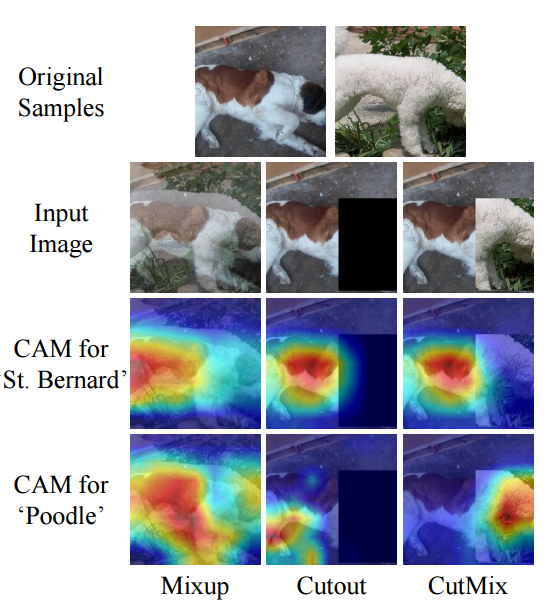